## Задача 3.

### 1.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from numpy import *
from scipy.stats import norm

In [2]:
train = pd.read_csv('12. times 1.txt', header=-1)
test = pd.read_csv('12. times 2.txt', header=-1)
train = list(train[0])
test = list(test[0])

Построим график для первого набора данных:

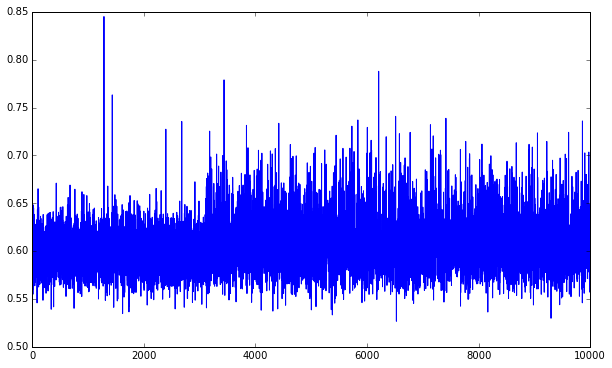

In [4]:
plt.figure(figsize=(10, 6))
bootsize = 10000
plt.plot(train[:bootsize])

Можно заметить, что момент разладки ~ 3500.

Найдем выборочное среднее и дисперсию на промежутках до и после разладки:

In [12]:
a1 = mean(train[:2000])
sigma1 = var(train[:2000], ddof=1)
print("a1 = ", a1, "sigma1 = ", sigma1)

a1 =  0.6006697584 sigma1 =  0.000460493926099


In [13]:
a2 = mean(train[-2000:])
sigma2 = var(train[-2000:], ddof=1)
print("a2 = ", a2, "sigma2 = ", sigma2)

a2 =  0.60847611755 sigma2 =  0.000740322838731


Определим статистику CUSUM. 

На некоторых значениях из выборки $f(\xi)$ python округляет до нуля, поэтому явно считаем $log \frac{g(\xi)}{f(\xi)}$ при заданных параметрах.

In [14]:
def log_g_div_f(x, a1, sigma1, a2, sigma2):
    return (x - a1) ** 2 / sigma1 - (x - a2) ** 2 / sigma2 + .5 * log(sigma1/sigma2)

def CUSUM_statistics(t, a1, sigma1, a2, sigma2, X):
    S = 0
    for i in range(1, t+1):
        S = max(S + log_g_div_f(X[i], a1, sigma1, a2, sigma2), 0)
    return S

def disorder_moment(X, a1, sigma1, a2, sigma2, a = 0.000001):
    S = 0
    for i in range(len(X)):
        if S >= a:
            return i + 1
        S = max(S + log_g_div_f(X[i], a1, sigma1, a2, sigma2), 0)
    return -1   

Построим график статистики CUSUM для первого набора данных.

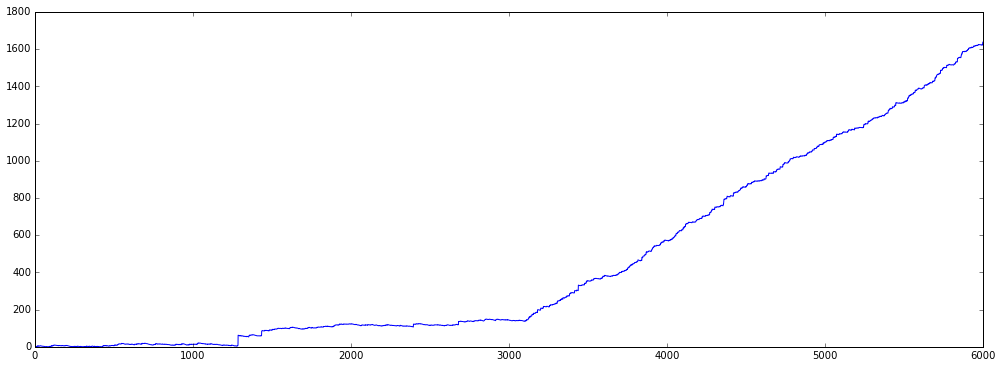

In [15]:
N1 = norm(loc=a1, scale=sigma1)
N2 = norm(loc=a2, scale=sigma2)
plt.figure(figsize=(17,6))
plt.plot([CUSUM_statistics(t, a1, sigma1, a2, sigma2, train) for t in range(6000)])

Видно, что момент разладки ~3100. Увеличим масшаб в этой области:

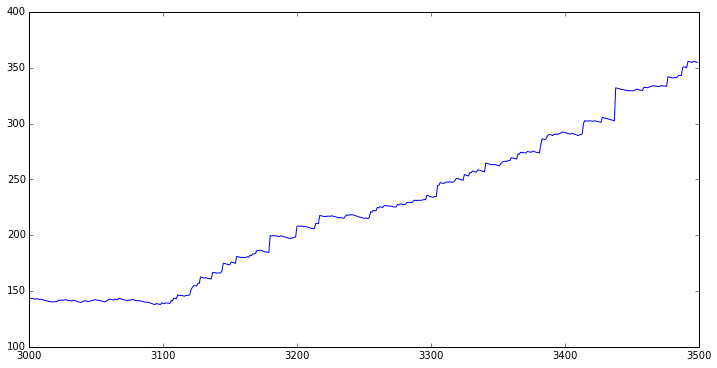

In [187]:
plt.figure(figsize=(12,6))
plt.plot(arange(3000, 3500), [CUSUM_statistics(t, a1, sigma1, a2, sigma2, train) for t in range(3000, 3500)])

Определим функцию сглаживания:

In [18]:
def EWMA(x):
    ewma = pd.stats.moments.ewma
    fwd = ewma( x, span=20 ) 
    bwd = ewma( x[::-1], span=20 )
    c = vstack(( fwd, bwd[::-1] )) 
    c = mean( c, axis=0 )
    return c


Определим момент разладки для сглаженных данных из первого набора.

In [24]:
train_smoothed = EWMA(array(train))
a1, sigma1 = mean(train_smoothed[:2000]), var(train_smoothed[:2000], ddof=1)
# sigma1 = 
print("a = ", a1, "sigma = ", sigma1)
a2, sigma2 = mean(train_smoothed[-2000:]), var(train_smoothed[-2000:], ddof=1)
# a2 = mean(train_smoothed[-2000:])
# sigma2 = var(train_smoothed[-2000:], ddof=1)
print("a = ", a2, "sigma = ", sigma2)

a =  0.600665096923 sigma =  1.30456399836e-05
a =  0.608459304453 sigma =  2.31388188407e-05


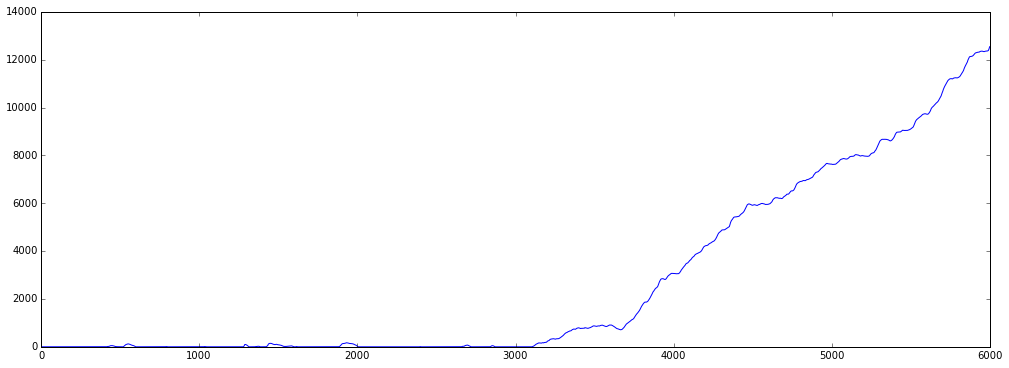

In [25]:
plt.figure(figsize=(17,6))
plt.plot([CUSUM_statistics(t, a1, sigma1, a2, sigma2, train_smoothed) for t in range(6000)])

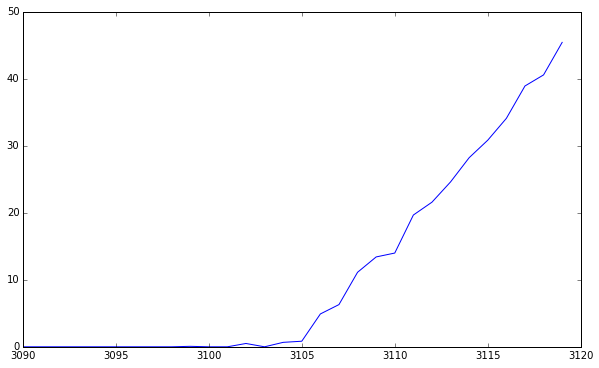

In [26]:
plt.figure(figsize=(10,6))
plt.plot(arange(3090, 3120), [CUSUM_statistics(t, a1, sigma1, a2, sigma2, train_smoothed) for t in range(3090, 3120)])

Получаем, что момент разладки ~ 3103.

Определим момент разладки для второго набора данных.

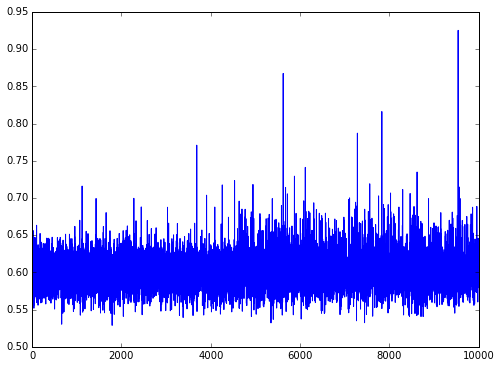

In [145]:
plt.figure(figsize=(8, 6))
plt.plot(test)

In [152]:
test_smoothed = EWMA(array(test))

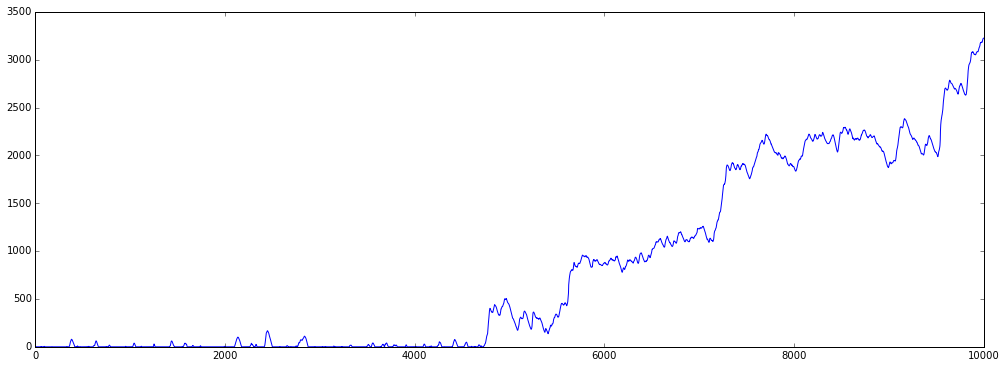

In [155]:
plt.figure(figsize=(17,6))
plt.plot([CUSUM_statistics(t, a1, sigma1, a2, sigma2, test_smoothed) for t in range(10000)])

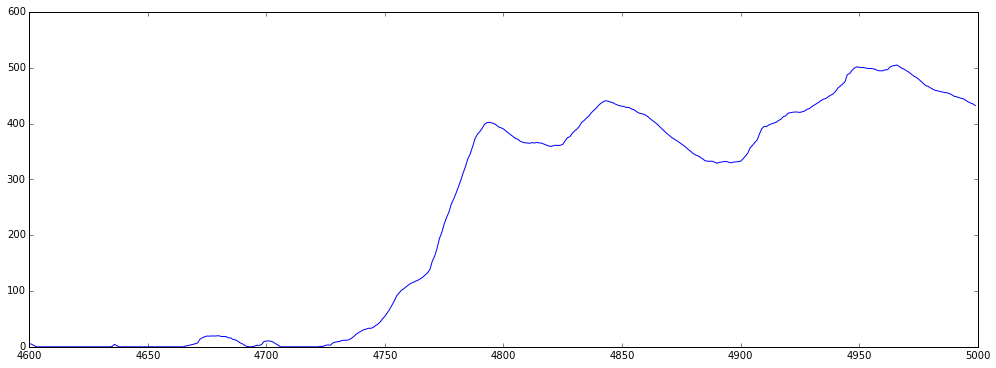

In [159]:
plt.figure(figsize=(17,6))
plt.plot(arange(4600, 5000), [CUSUM_statistics(t, a1, sigma1, a2, sigma2, test_smoothed) for t in range(4600, 5000)])

In [173]:
N11 = norm(loc=a1, scale=sigma1)
N21 = norm(loc=a2, scale=sigma2)
a = CUSUM_statistics(4724, a1, sigma1, a2, sigma2, test_smoothed)
print(a)
teta = disorder_moment(test_smoothed[4720:], a1, sigma1, a2, sigma2, a) + 4720
print("teta=", teta)

0.81763473438
teta= 4725


Получаем, что момент разладки $\theta = 4725$.

### 2.

Используем динамику курса швейцарского франка к голландскому гульдену за 14 лет(1988-2001). 

In [27]:
currency = []
with open('frank_quotes.csv', 'r') as f:
    data = f.readlines()
    for line in data:
        line = line.strip()
        words = line.split(';')
        if (len(words[2]) > 0):
            currency.append(float(words[2].strip('"')))
        
currency = list(reversed(currency))

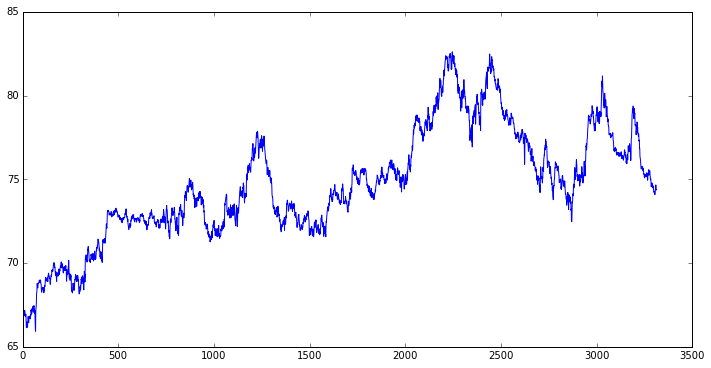

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(currency)

Построим график изменения курса:

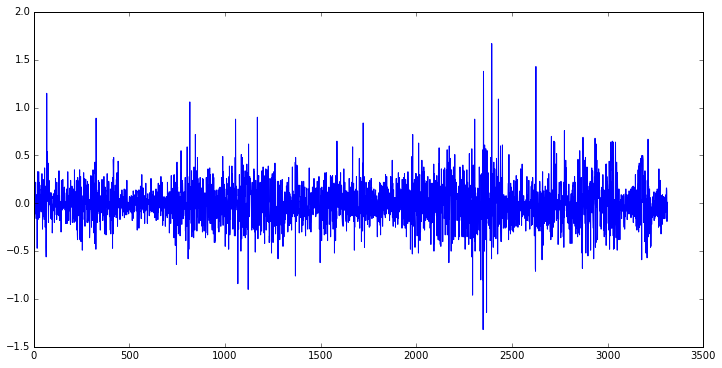

In [29]:
delta = []
for i in range(1, len(currency)):
    delta.append(currency[i] - currency[i-1])

plt.figure(figsize=(12, 6))
plt.plot(delta)

In [31]:
delta_smoothed = EWMA(array(delta))

a1, sigma1 = mean(delta_smoothed[:300]), var(delta_smoothed[:300], ddof=1)
print("a = ", a1, "sigma = ", sigma1)
a2, sigma2 = mean(delta_smoothed[500:700]), var(delta_smoothed[500:700], ddof=1)
print("a = ", a2, "sigma = ", sigma2)

a =  0.00473174445231 sigma =  0.000786863287805
a =  -0.00198967317801 sigma =  0.000156063787795


Попробуем найти моменты разладки для разных промежутков.

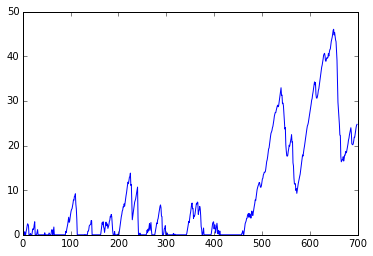

In [33]:
plt.plot([CUSUM_statistics(t, a1, sigma1, a2, sigma2, delta_smoothed) for t in range(700)])

In [34]:
t = CUSUM_statistics(463, a1, sigma1, a2, sigma2, delta_smoothed)
t

0.73640250330466661

Момент разладки на участке [0,700] равен 463.

a =  0.0193478244972 sigma =  0.000993461704041
a =  0.0121432934846 sigma =  0.00184707176868


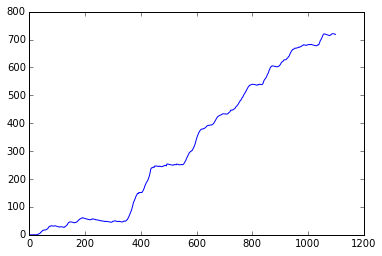

In [35]:
a1, sigma1 = mean(delta_smoothed[1900:2250]), var(delta_smoothed[1900:2250], ddof=1)
print("a = ", a1, "sigma = ", sigma1)
a2, sigma2 = mean(delta_smoothed[2700:3000]), var(delta_smoothed[2700:3000], ddof=1)
print("a = ", a2, "sigma = ", sigma2)

plt.plot([CUSUM_statistics(t, a1, sigma1, a2, sigma2, delta_smoothed[1900:3000]) for t in range(1,1100)])

In [36]:
t1 = CUSUM_statistics(350, a1, sigma1, a2, sigma2, delta_smoothed[1900:3000])
t2 = CUSUM_statistics(370, a1, sigma1, a2, sigma2, delta_smoothed[1900:3000])
t1, t2

(52.231701388812084, 95.719824707630622)

Момент разладки на участке [1900,3000] равен 2250.

a =  -0.0112391071382 sigma =  0.000401298857804
a =  0.00108868132094 sigma =  0.00147289314048


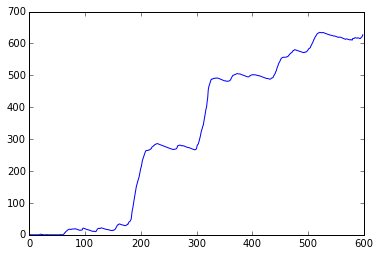

In [37]:
a1, sigma1 = mean(delta_smoothed[1400:1500]), var(delta_smoothed[1400:1500], ddof=1)
print("a = ", a1, "sigma = ", sigma1)

a2, sigma2 = mean(delta_smoothed[1800:2000]), var(delta_smoothed[2100:2300], ddof=1)
print("a = ", a2, "sigma = ", sigma2)
plt.plot([CUSUM_statistics(t, a1, sigma1, a2, sigma2, delta_smoothed[1400:2000]) for t in range(1,600)])

In [38]:
t1 = CUSUM_statistics(183, a1, sigma1, a2, sigma2, delta_smoothed[1400:2000])
t2 = CUSUM_statistics(190, a1, sigma1, a2, sigma2, delta_smoothed[1400:2000])
t1, t2

(46.061393022933082, 118.85116573726327)

Момент разладки на участке [1400,2000] равен 1583.

a =  -0.0232369210838 sigma =  0.000367806668201
a =  -0.0143918493773 sigma =  0.00166602693598


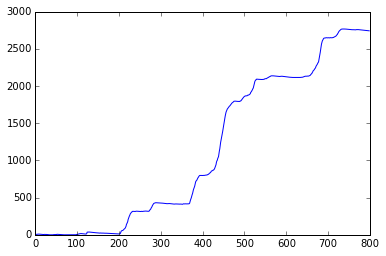

In [39]:
a1, sigma1 = mean(delta_smoothed[2500:2700]), var(delta_smoothed[2500:2700], ddof=1)
print("a = ", a1, "sigma = ", sigma1)
a2, sigma2 = mean(delta_smoothed[3000:3300]), var(delta_smoothed[3000:3300], ddof=1)
print("a = ", a2, "sigma = ", sigma2)

plt.plot([CUSUM_statistics(t, a1, sigma1, a2, sigma2, delta_smoothed[2500:3300]) for t in range(1,800)])

In [40]:
t1 = CUSUM_statistics(200, a1, sigma1, a2, sigma2, delta_smoothed[2500:3300])
t2 = CUSUM_statistics(202, a1, sigma1, a2, sigma2, delta_smoothed[2500:3300])
t1, t2

(10.652300028391947, 12.73922559983138)

Момент разладки на участке [2500,3300] равен 2700.

Таким образом, нашли четыре момента разладки:

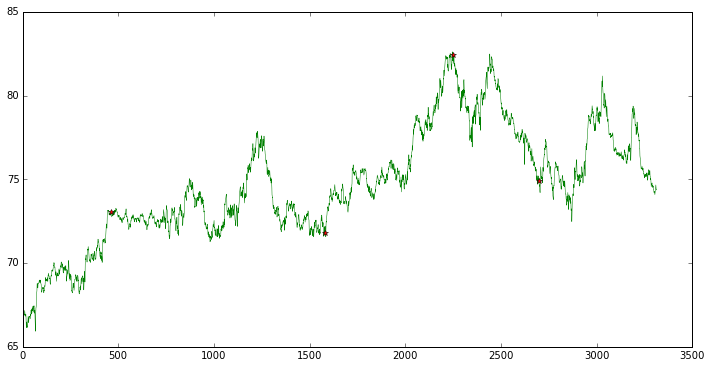

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(currency, 'g', lw='0.5')
x = [463, 1583, 2250, 2700]
y = [currency[i] for i in x]
plt.plot(x, y, 'r*')